In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs
    )

from model import UNET

In [3]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 # 1e-4 originally
Batch_size  = 16
num_epochs  = 10
num_workers = 4
IMAGE_HEIGHT = 64 # 512 originally
IMAGE_WIDTH  = 64 # 512 originally
PIN_MEMORY = True
LOAD_MODEL = True
CHECKPOINT_NAME = "checkpoint_7_2025-03-23_21-45-18.pth.tar"
IMG_DIR      =  "E:/Code/MRI-Segmentation-Preprocess/Brain Tumor Segmentation/images"
MASK_DIR     =  "E:/Code/MRI-Segmentation-Preprocess/Brain Tumor Segmentation/masks"
VAL_IMG_DIR  =  "E:/Code/MRI-Segmentation-Preprocess/Brain Tumor Segmentation/val_images"
VAL_MASK_DIR =  "E:/Code/MRI-Segmentation-Preprocess/Brain Tumor Segmentation/val_masks"

In [3]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        # targets must be float for BCELoss (Binary Cross Entropy Loss)
        targets = targets.float().unsqueeze(1).to(device=Device) 

        # forward
        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [4]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = UNET(in_channel=1, out_channel=1).to(Device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        # load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        check_accuracy(val_loader, model, device=Device)
        
    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":  optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=Device)

        # print some examples to a folder
        if epoch != num_epochs - 1:
            save_predictions_as_imgs(
                val_loader, model, folder="saved_images/", device=Device, show_last_epoch=False 
            )
        else:
            save_predictions_as_imgs(
                val_loader, model, folder="saved_images/", device=Device, show_last_epoch=True 
            )

✅ Loaded checkpoint: checkpoint_7_2025-03-23_21-45-18.pth.tar
Got 168433/176128 with acc 95.63
Dice score: 0.13414622843265533


100%|██████████| 192/192 [01:13<00:00,  2.62it/s, loss=0.142]


✅ Checkpoint saved: checkpoint_20_2025-03-23_23-55-02.pth.tar
Got 174555/176128 with acc 99.11
Dice score: 0.5958200693130493


100%|██████████| 192/192 [01:13<00:00,  2.61it/s, loss=0.1]  


✅ Checkpoint saved: checkpoint_21_2025-03-23_23-56-33.pth.tar
Got 174977/176128 with acc 99.35
Dice score: 0.7514710426330566


100%|██████████| 192/192 [01:13<00:00,  2.62it/s, loss=0.0885]


✅ Checkpoint saved: checkpoint_22_2025-03-23_23-58-04.pth.tar
Got 175013/176128 with acc 99.37
Dice score: 0.7523008584976196


100%|██████████| 192/192 [01:13<00:00,  2.61it/s, loss=0.0824]


✅ Checkpoint saved: checkpoint_23_2025-03-23_23-59-35.pth.tar
Got 175070/176128 with acc 99.40
Dice score: 0.770799994468689


100%|██████████| 192/192 [01:13<00:00,  2.60it/s, loss=0.0639]


✅ Checkpoint saved: checkpoint_24_2025-03-24_00-01-07.pth.tar
Got 175237/176128 with acc 99.49
Dice score: 0.7998322248458862


100%|██████████| 192/192 [01:15<00:00,  2.55it/s, loss=0.0582]


✅ Checkpoint saved: checkpoint_25_2025-03-24_00-02-44.pth.tar
Got 175219/176128 with acc 99.48
Dice score: 0.7844799757003784


100%|██████████| 192/192 [01:15<00:00,  2.54it/s, loss=0.0478]


✅ Checkpoint saved: checkpoint_26_2025-03-24_00-04-21.pth.tar
Got 175059/176128 with acc 99.39
Dice score: 0.734674334526062


100%|██████████| 192/192 [01:15<00:00,  2.55it/s, loss=0.0426]


✅ Checkpoint saved: checkpoint_27_2025-03-24_00-05-57.pth.tar
Got 175158/176128 with acc 99.45
Dice score: 0.757495105266571


100%|██████████| 192/192 [01:14<00:00,  2.58it/s, loss=0.0297]


✅ Checkpoint saved: checkpoint_28_2025-03-24_00-07-32.pth.tar
Got 175227/176128 with acc 99.49
Dice score: 0.7775688171386719


100%|██████████| 192/192 [01:15<00:00,  2.53it/s, loss=0.0423]


✅ Checkpoint saved: checkpoint_29_2025-03-24_00-09-07.pth.tar
Got 175092/176128 with acc 99.41
Dice score: 0.7208515405654907


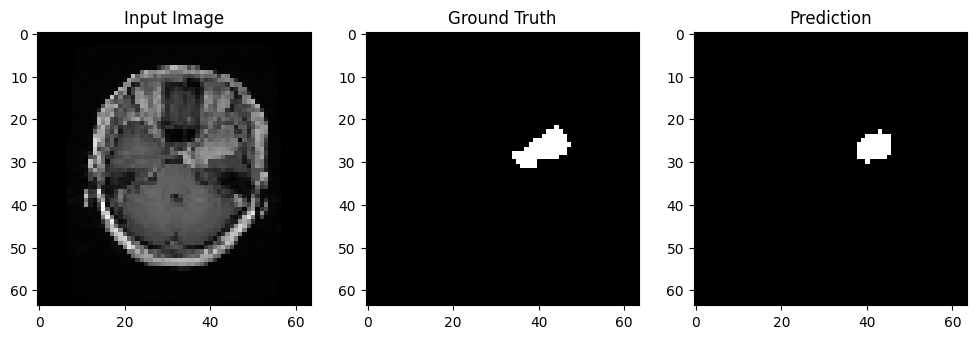

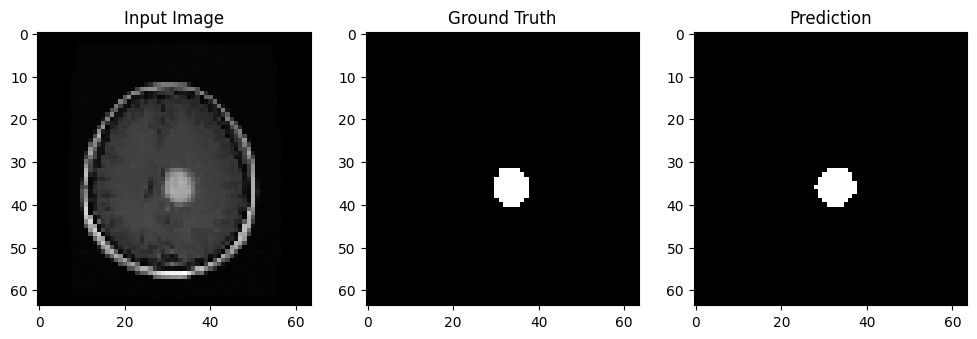

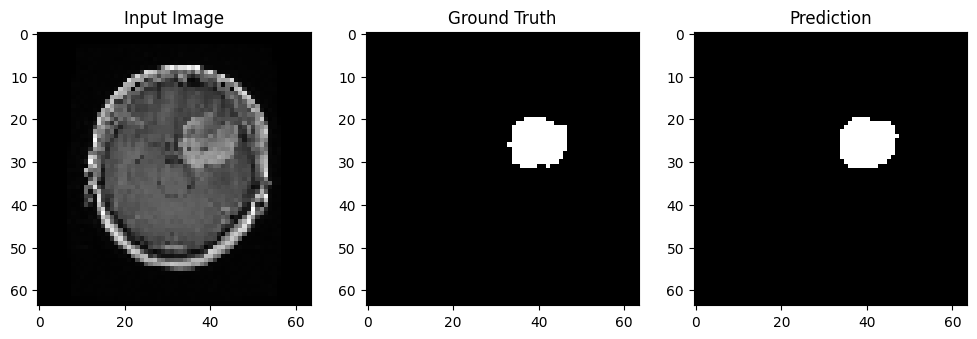

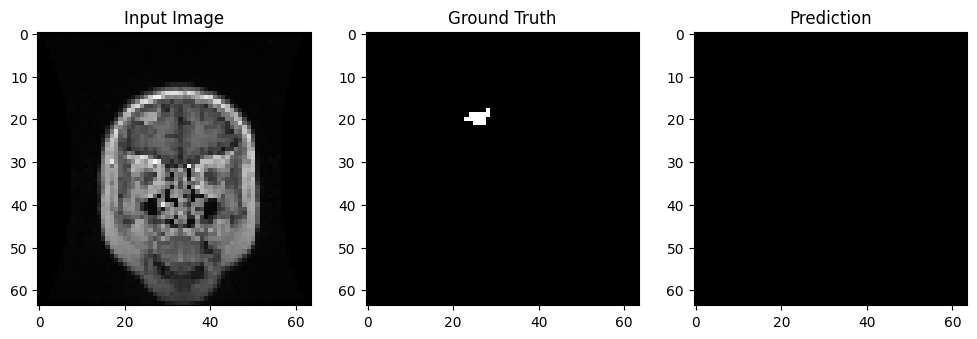

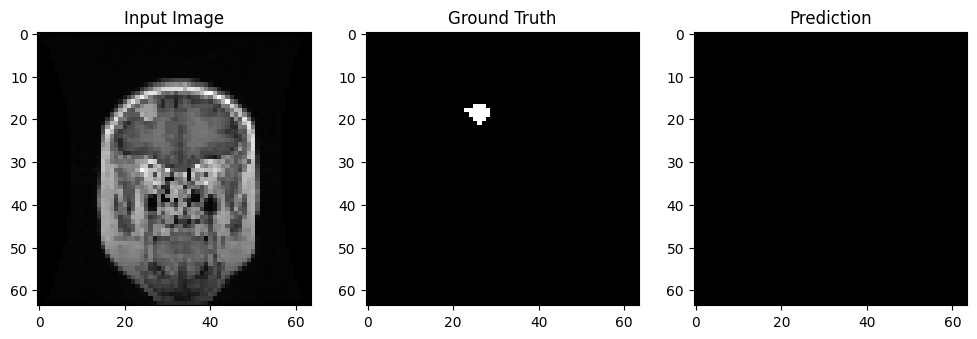

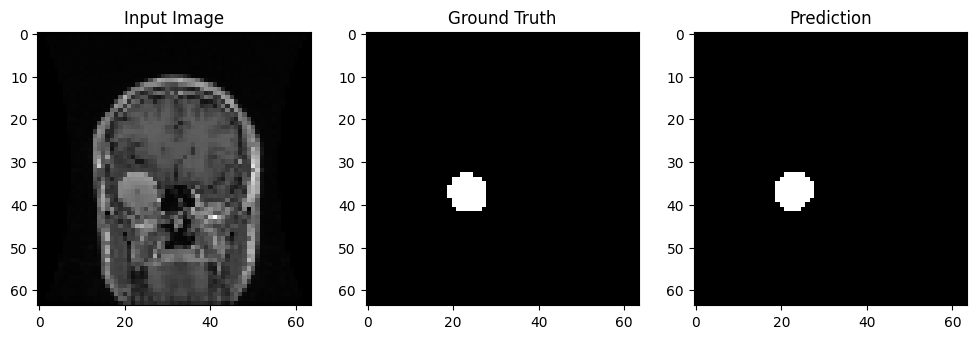

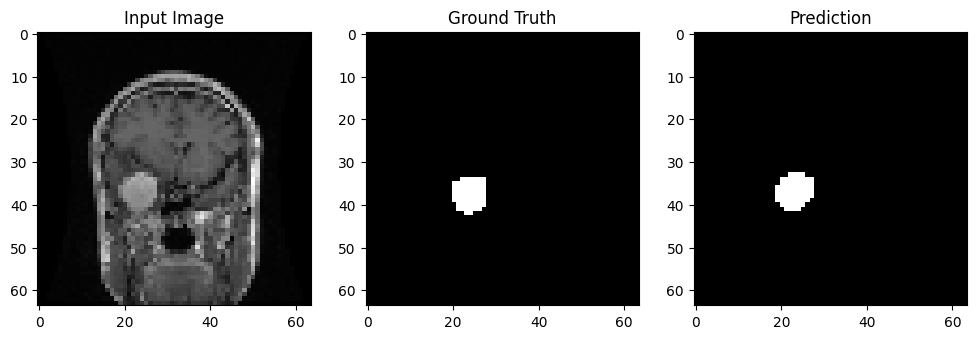

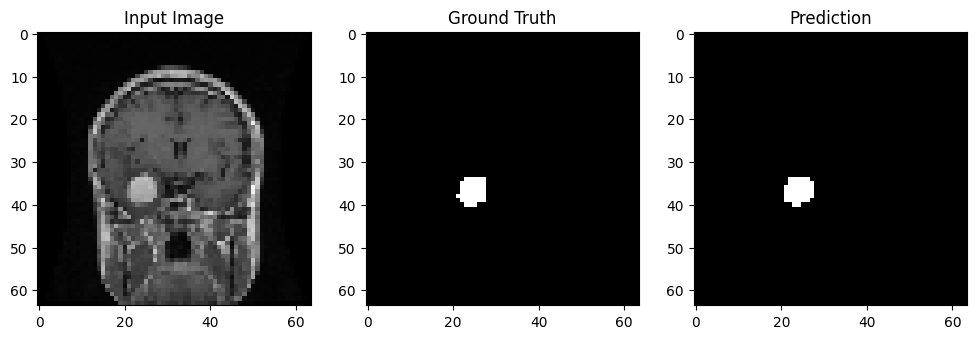

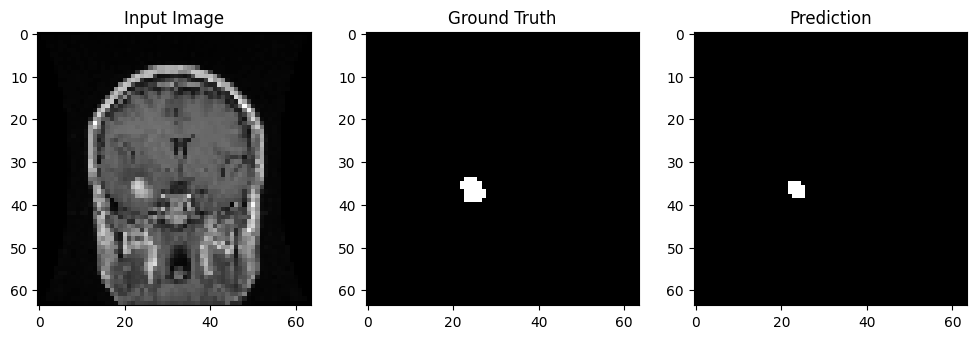

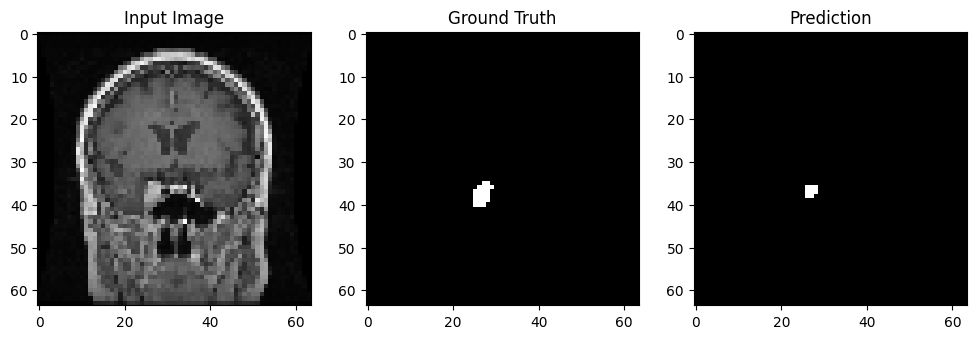

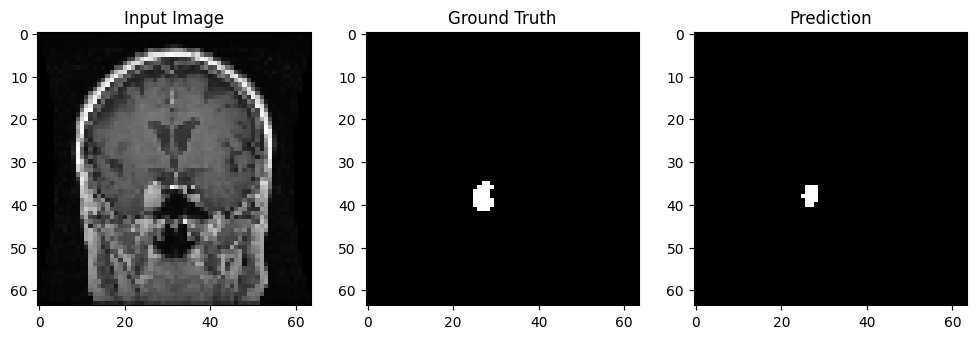

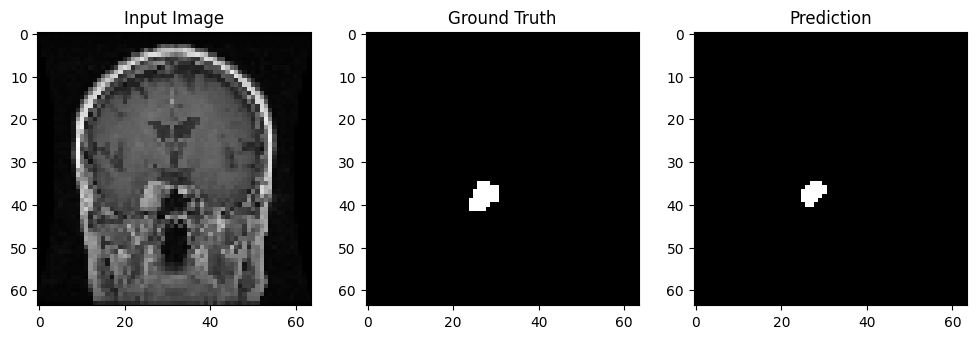

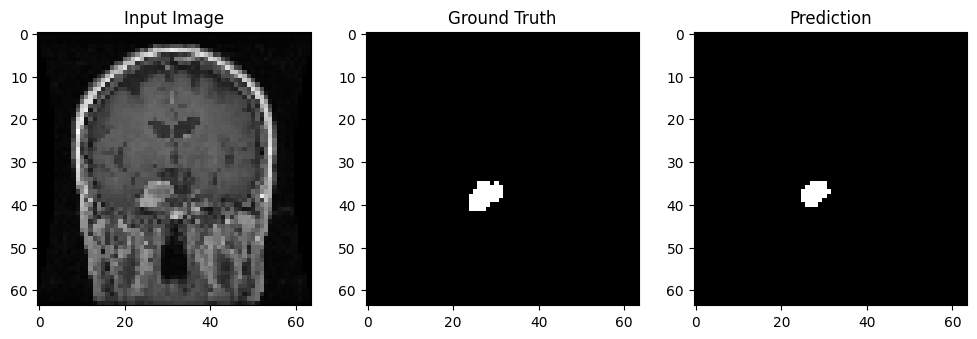

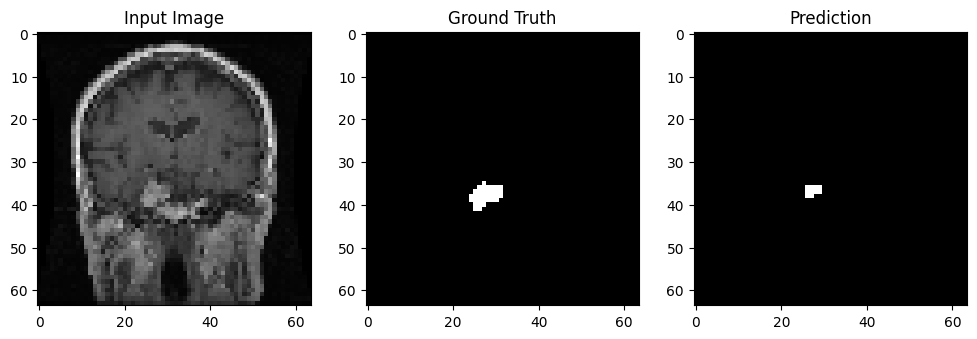

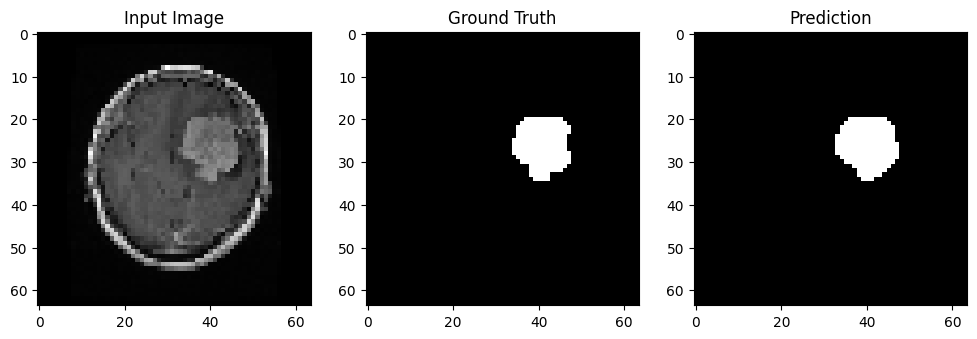

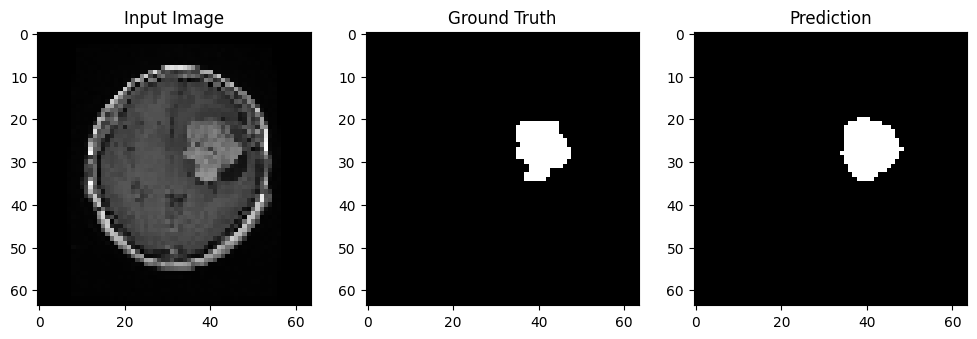

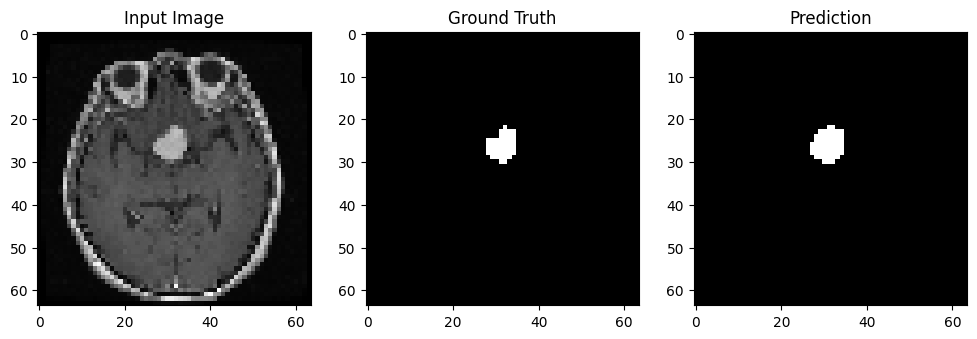

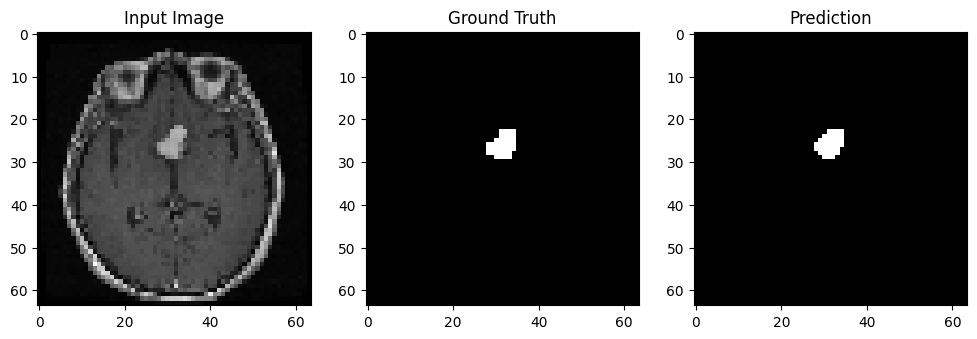

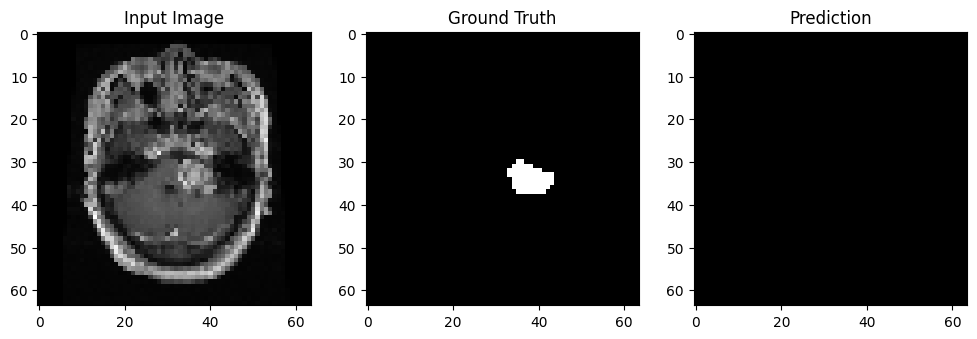

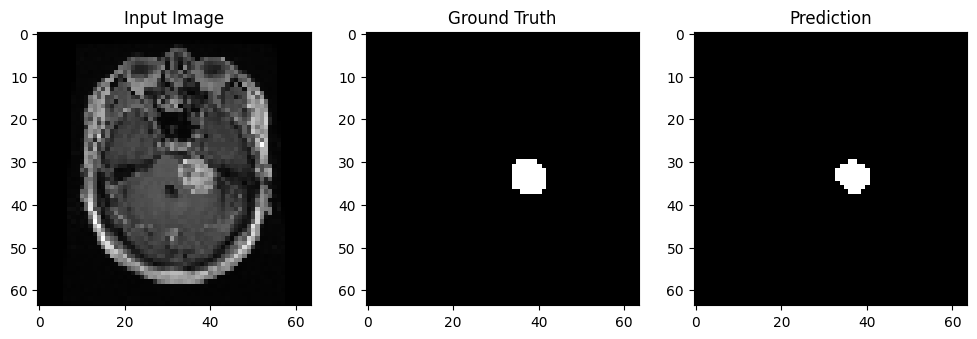

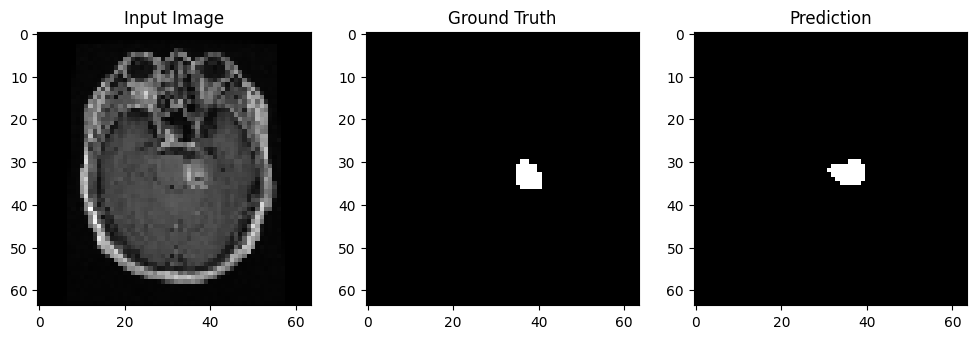

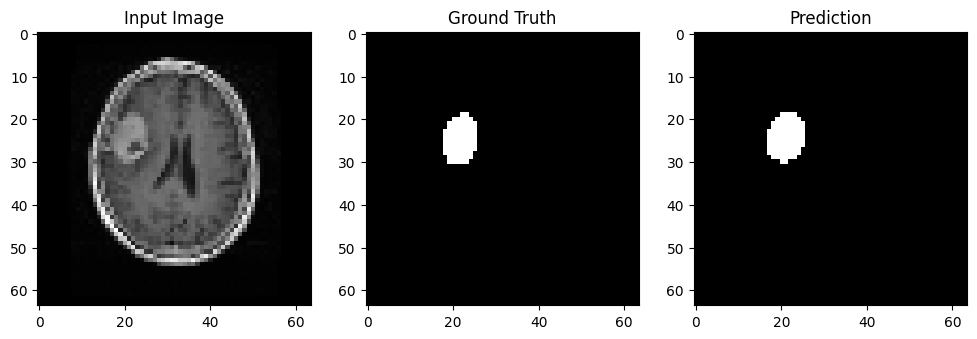

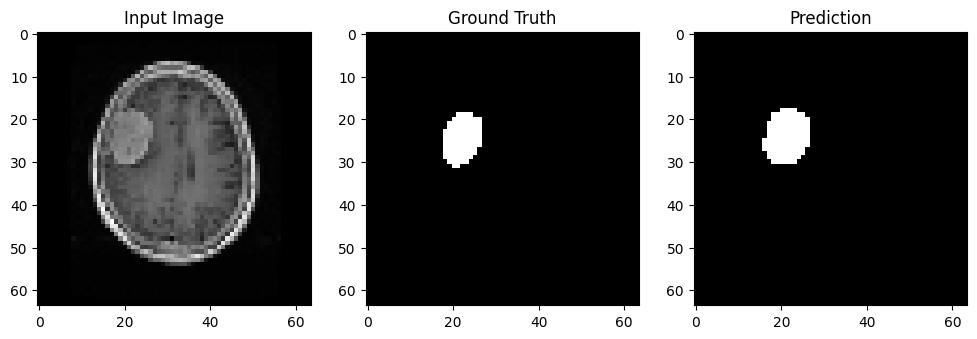

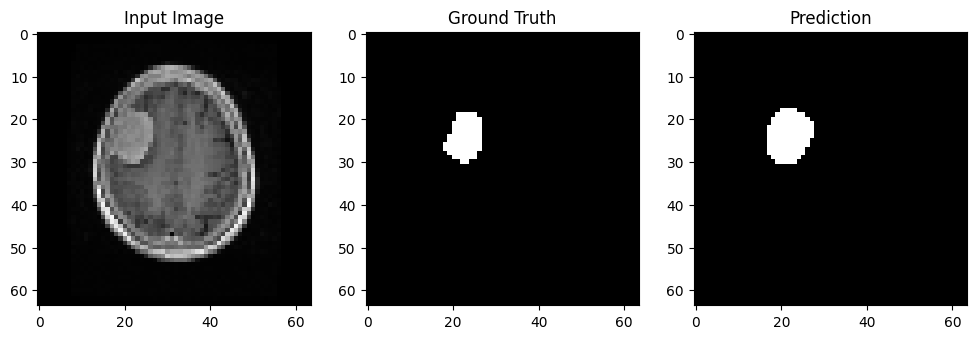

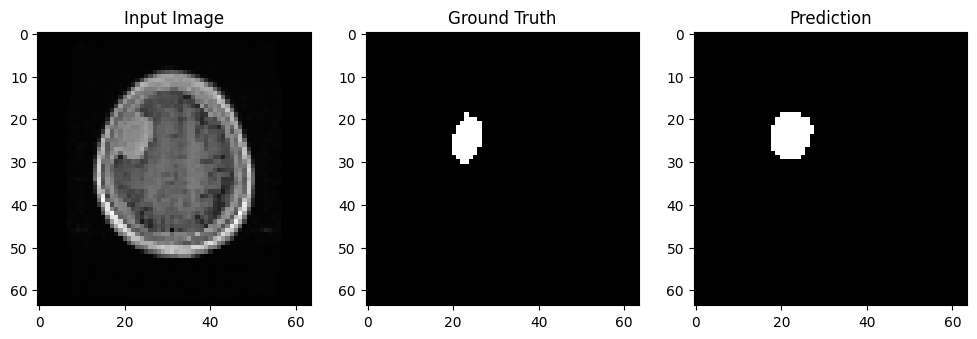

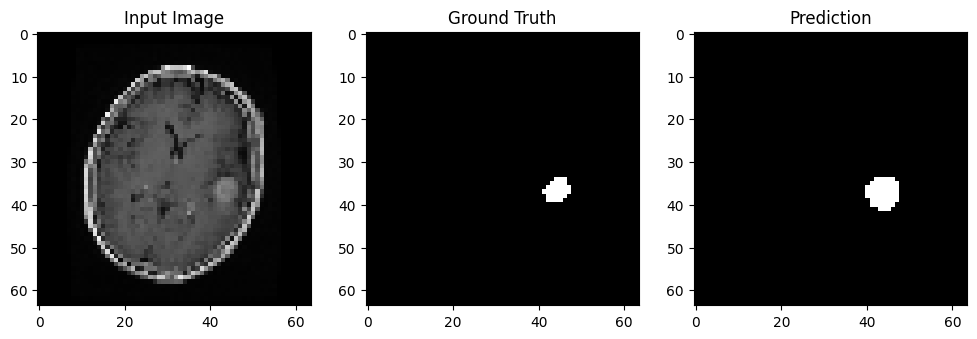

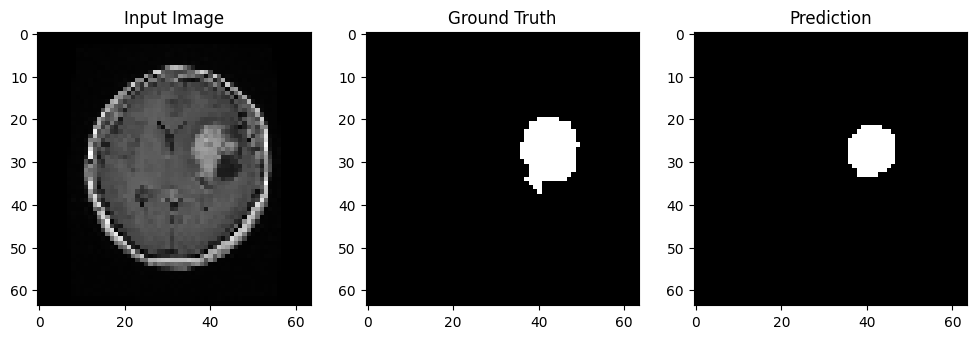

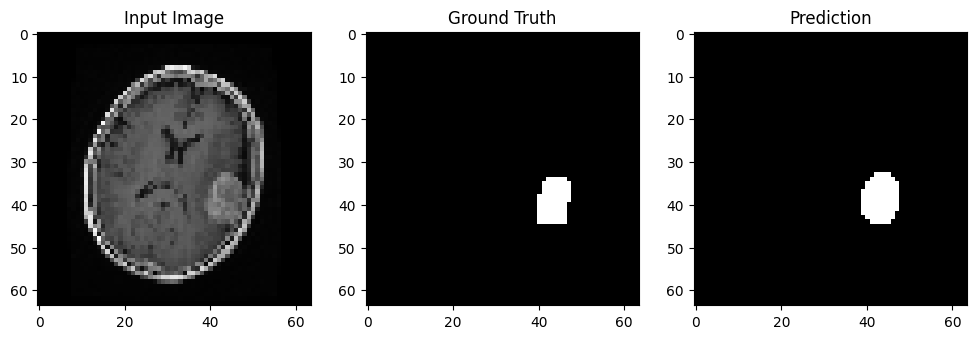

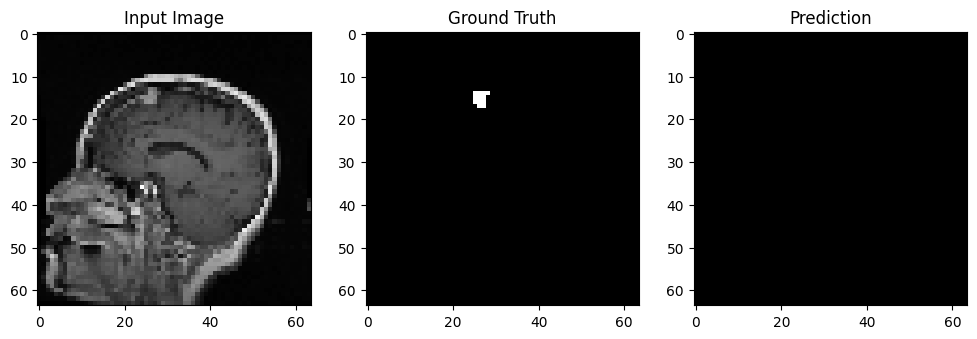

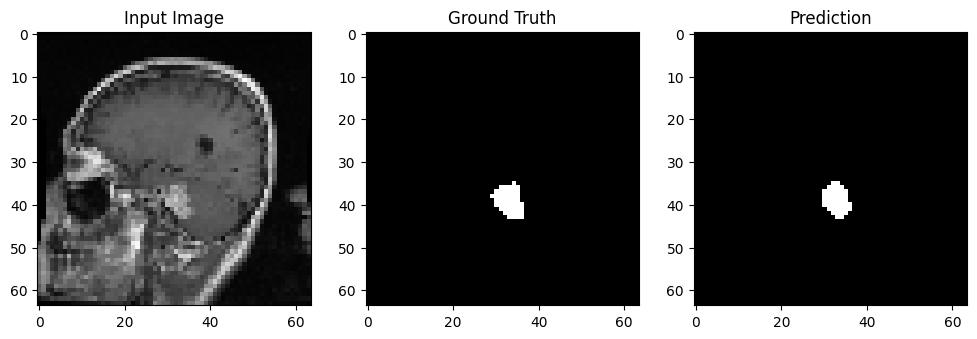

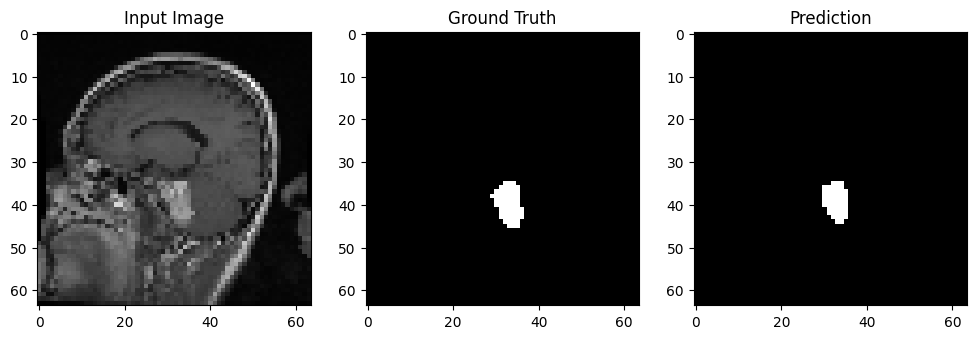

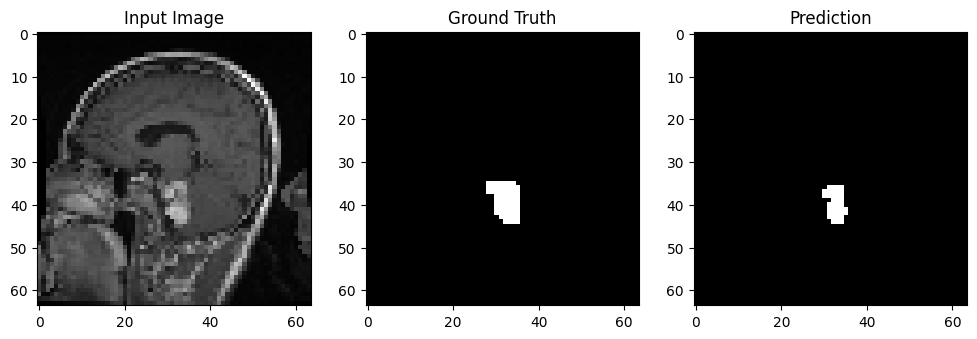

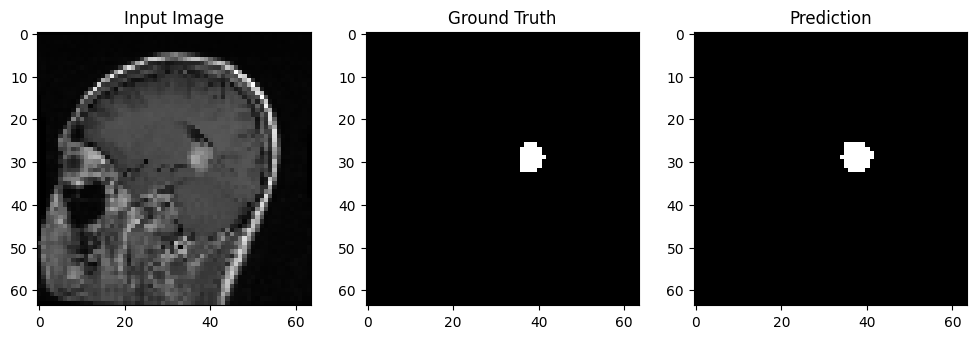

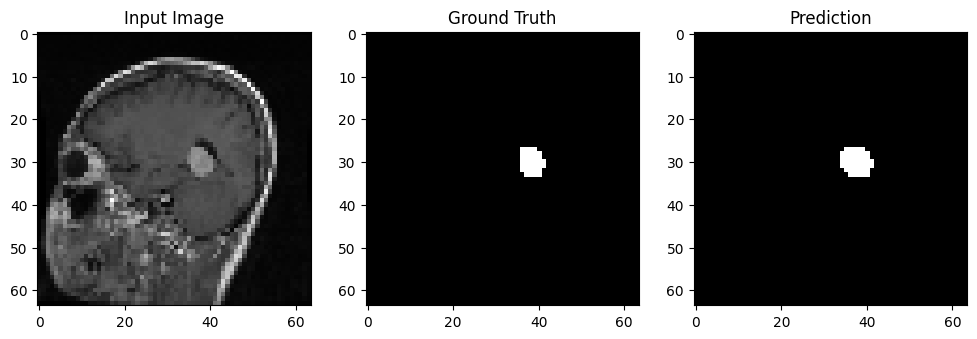

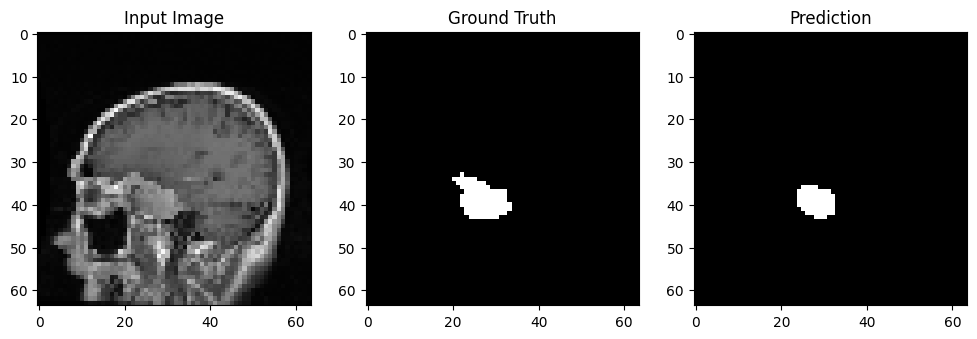

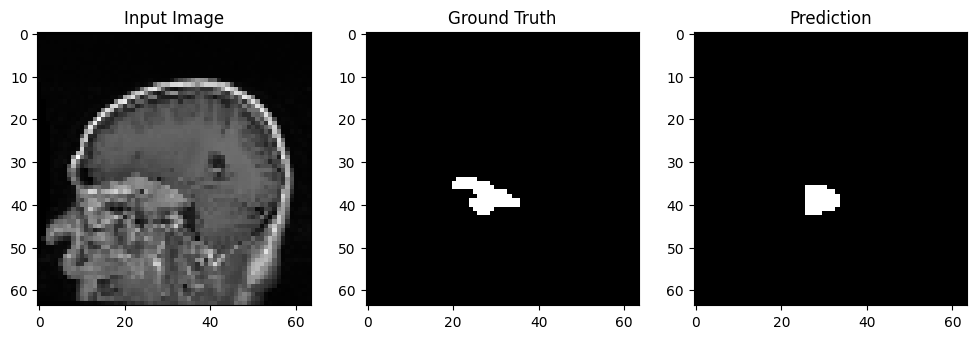

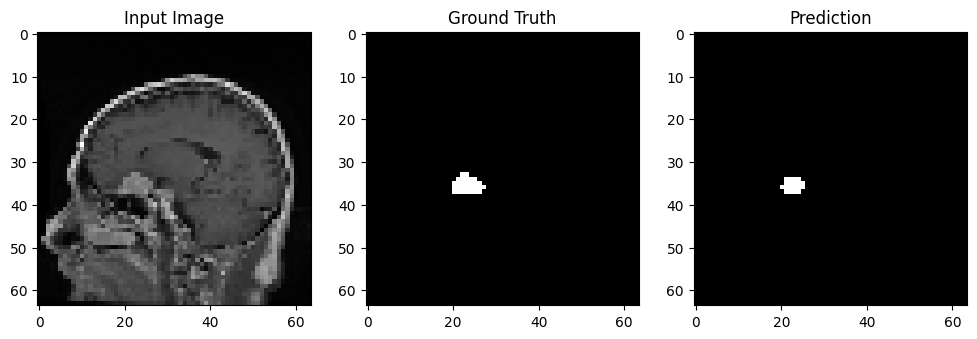

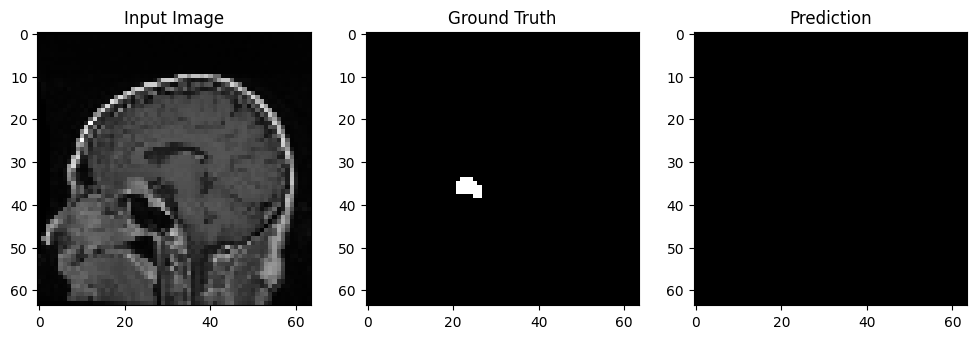

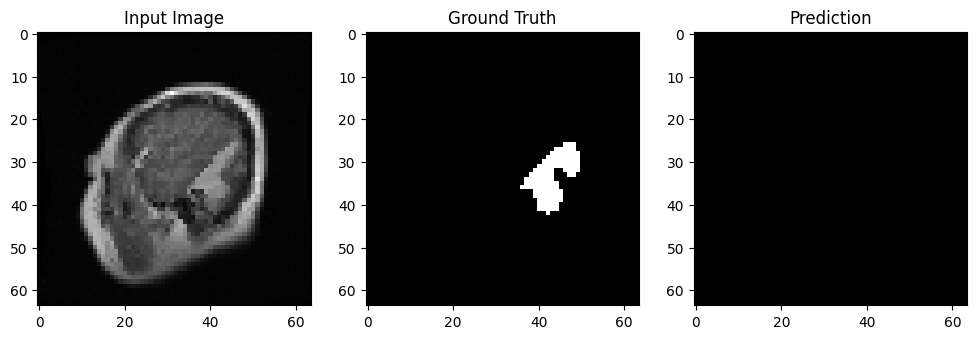

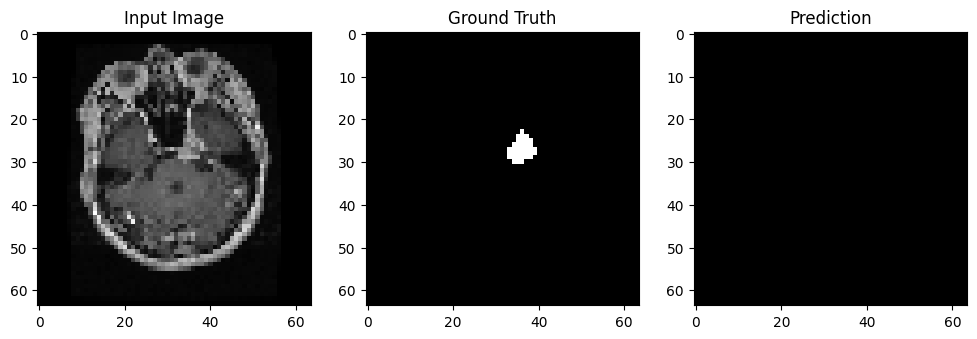

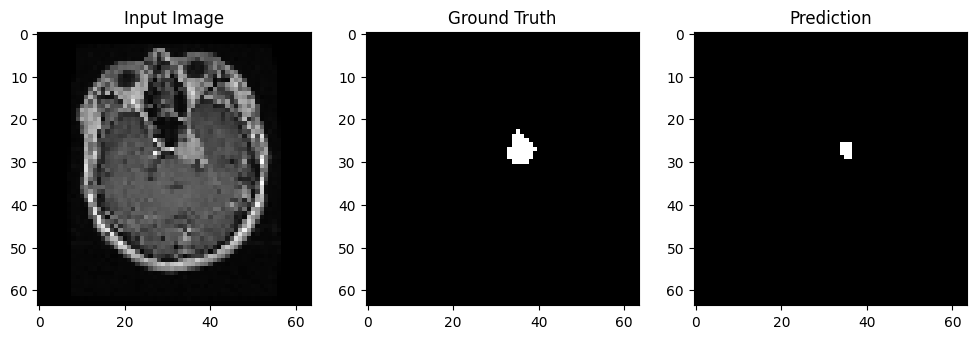

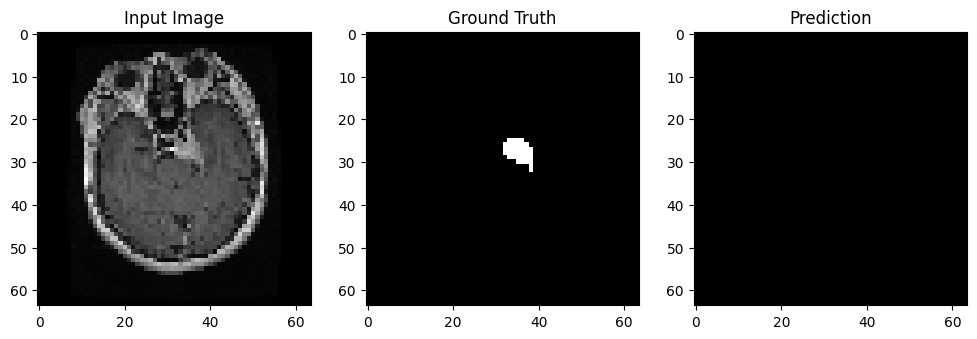

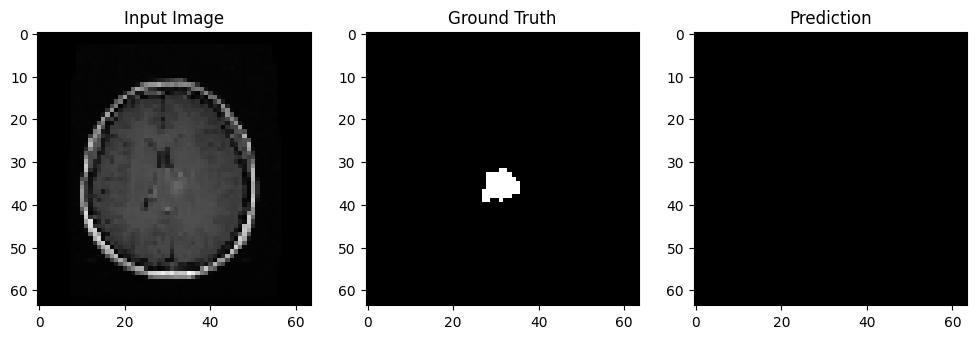

In [5]:
if __name__ == "__main__": 
    main()

## Checking checkpoint params

In [7]:
def inspect_checkpoint(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        print(f"📁 Keys in checkpoint: {list(checkpoint.keys())}")
        print(f"📌 Saved at Epoch: {checkpoint.get('epoch', 'N/A')}")

        # Inspect model parameters
        model_state = checkpoint.get("state_dict", {})
        print(f"🧠 Total Parameters: {len(model_state)}")
        print("\n🔍 First 5 parameters:")
        for i, (key, value) in enumerate(model_state.items()):
            print(f"{i+1}. {key}: {tuple(value.shape)}")
            if i >= 4:
                break

        # Optional: Inspect optimizer state if needed
        if "optimizer" in checkpoint:
            print("\n🛠 Optimizer state found.")

    except Exception as e:
        print(f"❌ Error inspecting checkpoint: {e}")

# inspect_checkpoint("E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/unet/checkpoints/Collab/checkpoint_5_2025-03-26_05-42-36.pth.tar")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(UNET(in_channel=1, out_channel=1).to(device), input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 256, 256]             576
       BatchNorm2d-2         [32, 64, 256, 256]             128
              ReLU-3         [32, 64, 256, 256]               0
            Conv2d-4         [32, 64, 256, 256]          36,864
       BatchNorm2d-5         [32, 64, 256, 256]             128
              ReLU-6         [32, 64, 256, 256]               0
        DoubleConv-7         [32, 64, 256, 256]               0
         MaxPool2d-8         [32, 64, 128, 128]               0
            Conv2d-9        [32, 128, 128, 128]          73,728
      BatchNorm2d-10        [32, 128, 128, 128]             256
             ReLU-11        [32, 128, 128, 128]               0
           Conv2d-12        [32, 128, 128, 128]         147,456
      BatchNorm2d-13        [32, 128, 128, 128]             256
             ReLU-14        [32, 128, 1

## Grad-CAM saliency maps for multiple images using a loaded checkpoint

In [ ]:
def load_and_preprocess_image(image_path):
    transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.0,), std=(1.0,), max_pixel_value=255.0),
    ToTensorV2(),
    ])
    image = Image.open(image_path).convert("L")
    image_rgb = Image.open(image_path).convert("RGB")
    processed = transform(image=np.array(image))
    input_tensor = processed['image'].unsqueeze(0)
    vis_image = np.array(image_rgb.resize((256, 256))) / 255.0
    return input_tensor, vis_image

def generate_gradcam_from_path(model, image_paths, mask_paths, target_layer, device="cuda", save_folder="./gradcam_results"):
    transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.0,), std=(1.0,), max_pixel_value=255.0),
    ToTensorV2(),
    ])

    model.to(device).eval()
    os.makedirs(save_folder, exist_ok=True)

    cam = GradCAM(model=model, target_layers=[target_layer])

    for idx, image_path in enumerate(image_paths):
        input_tensor, vis_image = load_and_preprocess_image(image_path)
        input_tensor = input_tensor.to(device)

        loaded_input_mask_tensor, _ = load_and_preprocess_image(mask_paths[idx])
        input_mask_tensor = loaded_input_mask_tensor.squeeze(0).cpu().numpy()

        targets = [SemanticSegmentationTarget(0,input_mask_tensor)]

        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        cam_image = show_cam_on_image(vis_image, grayscale_cam, use_rgb=True)

        plt.figure(figsize=(10, 15))

        plt.subplot(3, 1, 1)
        plt.imshow(vis_image)
        plt.axis("off")
        plt.title(f"Original Image for {os.path.basename(image_path)}")

        plt.subplot(3, 1, 2)
        plt.imshow(loaded_input_mask_tensor.cpu().squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"Mask for {os.path.basename(image_path)}")

        plt.subplot(3, 1, 3)
        plt.imshow(cam_image)
        plt.axis("off")
        plt.title(f"Grad-CAM for {os.path.basename(image_path)}")

        save_path = os.path.join(save_folder, f"Grad-CAM_idx_{idx}_num_{os.path.basename(image_path)}")
        counter = 1
        while os.path.exists(save_path):
            save_path = os.path.join(save_folder, f"Grad-CAM_idx_{idx}_num_{os.path.basename(image_path)}_{counter}")
            counter += 1
        plt.savefig(save_path)

        plt.show()

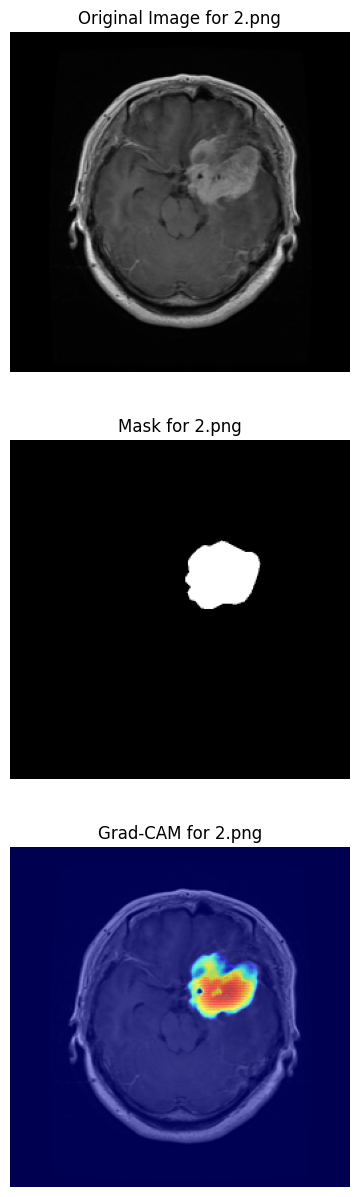

In [48]:
model = UNET(in_channel=1, out_channel=1)
checkpoint = torch.load("E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/unet/checkpoints/Collab/checkpoint_5_2025-03-26_05-42-36.pth.tar", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])

# target_layer = model.bottleneck.conv[-1] 
# target_layer = model.final_conv 
target_layer = model.ups[-1] 

image_paths = [
    "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/images/2.png"
]
mask_paths = [
    "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/masks/2.png"
]

generate_gradcam_from_path(model, image_paths, mask_paths, target_layer)